### Notebook for testing my code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
my_path="data"
df=pd.read_csv(f"{my_path}/creditcard.csv")


### Modify Time variable:

In [3]:
df["Hours"] = df["Time"] // 3600

### Some fast visualizations

In [4]:
df.groupby('Class').size()
outlier_fraction = df['Class'].sum()/len(df)
print("proportion of frauds: ", outlier_fraction )
print("number of fraud transactions: ",df['Class'].sum())

proportion of frauds:  0.001727485630620034
number of fraud transactions:  492


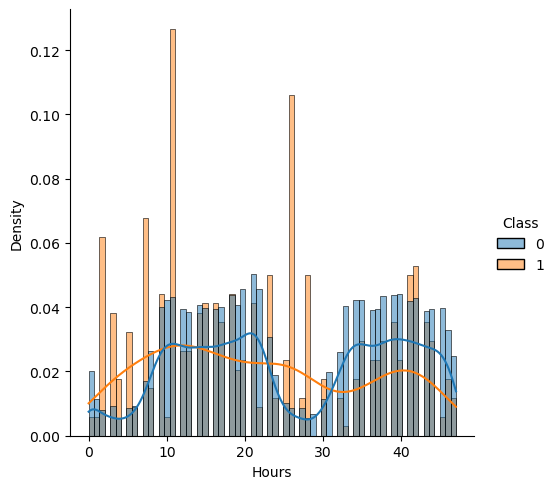

In [5]:
sns.displot(data=df,x='Hours',hue='Class', kde=True,stat='density', common_norm=False)

<Figure size 1000x600 with 0 Axes>

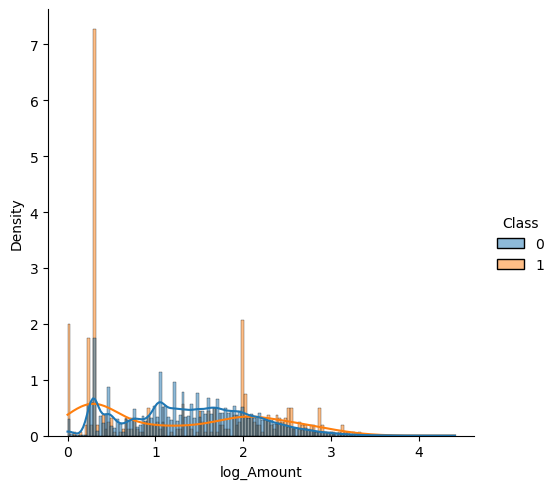

In [6]:
df["log_Amount"] = np.log10(df["Amount"] + 1)
plt.figure(figsize=(10,6))
sns.displot(data=df,x='log_Amount',hue='Class', kde=True,stat='density', common_norm=False)
plt.show()

### Split the data

In [7]:
x=df.drop(columns=["Class"])
y=df["Class"]
x_clean=x[y==0]
y_clean=y[y==0]
x_fraud=x[y==1]
y_fraud=y[y==1]
x_train, x_test, y_train, y_test = train_test_split(x_clean,y_clean,test_size=0.2, random_state=1)

In [8]:
x_test = pd.concat([x_test, x_fraud], axis=0)
y_test = pd.concat([y_test, y_fraud], axis=0)

###
For the following we want to predict 1 000 observations like possibly fraudulent transactions, so we use the `pourcent` as the `contamination` parameter in the Isolation Forest model.

In [9]:
predictict_outlier=1000
pourcent= predictict_outlier/len(x_test)
print("proportion of predicted outliers: ", pourcent)

proportion of predicted outliers:  0.01743527155435446


#### Isolation Forest

In [10]:
import importlib
from models import isolation_forest
from utils import evaluate_models
importlib.reload(isolation_forest)
importlib.reload(evaluate_models)
from models.isolation_forest import (
    train_isolation_forest,
    predict_isolation_forest
)     
from utils.evaluate_models import evaluate_model, print_evaluation

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [12]:

model = train_isolation_forest(x_train, contamination=pourcent,n_estimators=100)
y_pred_iso = predict_isolation_forest(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_iso))

Confusion Matrix:
[[55872   991]
 [  154   338]]

Classification Report:
Label 0:
  precision: 0.9973
  recall: 0.9826
  f1-score: 0.9899
  support: 56863.0000
Label 1:
  precision: 0.2543
  recall: 0.6870
  f1-score: 0.3712
  support: 492.0000


### SVM

In [12]:
import importlib
from models import svm
from utils import evaluate_models
importlib.reload(svm)
importlib.reload(evaluate_models)
from models.svm import (
    train_one_class_svm,
    predict_one_class_svm,
    train_sgd_one_class_svm,
    predict_sgd_one_class_svm
) 

### SVM one class 

In [101]:
model = train_one_class_svm(x_train, nu=0.01, kernel='rbf', gamma='scale')
y_pred_svm = predict_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm))

Confusion Matrix:
[[56147   716]
 [   84   408]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9874
  f1-score: 0.9929
  support: 56863.0000
Label 1:
  precision: 0.3630
  recall: 0.8293
  f1-score: 0.5050
  support: 492.0000


### SGD One Class SVM

In [102]:
model = train_sgd_one_class_svm(x_train, nu=0.01)
y_pred_svm_sgd = predict_sgd_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm_sgd))

Confusion Matrix:
[[    0 56863]
 [    0   492]]

Classification Report:
Label 0:
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  support: 56863.0000
Label 1:
  precision: 0.0086
  recall: 1.0000
  f1-score: 0.0170
  support: 492.0000


c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

### Local outlier factor

In [13]:
import importlib
from models import local_outiers_factor
from utils import evaluate_models
importlib.reload(local_outiers_factor)
importlib.reload(evaluate_models)
from models.local_outiers_factor import (
    train_local_outlier_factor,
    predict_local_outliers_factor
) 

In [15]:
model=train_local_outlier_factor(x_train, n_neighbors=20, contamination=pourcent)
y_pred_lof = predict_local_outliers_factor(model, x_test) 
print_evaluation(evaluate_model(y_test, y_pred_lof))


Confusion Matrix:
[[55888   975]
 [  467    25]]

Classification Report:
Label 0:
  precision: 0.9917
  recall: 0.9829
  f1-score: 0.9873
  support: 56863.0000
Label 1:
  precision: 0.0250
  recall: 0.0508
  f1-score: 0.0335
  support: 492.0000


In [ ]:
n_neighbors_list = [5, 10, 15, 20, 25, 30,35]
models_neighbors = {}

for n_neighbors in n_neighbors_list:
    # Train
    model = train_local_outlier_factor(
        x_train, 
        n_neighbors=n_neighbors, 
        contamination=pourcent
    )

    # keep
    models_neighbors[n_neighbors] = model

    # pred
    y_pred_lof = predict_local_outliers_factor(model, x_test)

    # plot evaluation
    print(f"\n=== n_neighbors: {n_neighbors} ===")
    print_evaluation(evaluate_model(y_test, y_pred_lof))


c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(



=== n_neighbors: 5 ===
Confusion Matrix:
[[56777    98]
 [   86     1]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9983
  f1-score: 0.9984
  support: 56875.0000
Label 1:
  precision: 0.0101
  recall: 0.0115
  f1-score: 0.0108
  support: 87.0000


c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(



=== n_neighbors: 10 ===
Confusion Matrix:
[[56777    98]
 [   86     1]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9983
  f1-score: 0.9984
  support: 56875.0000
Label 1:
  precision: 0.0101
  recall: 0.0115
  f1-score: 0.0108
  support: 87.0000

=== n_neighbors: 15 ===
Confusion Matrix:
[[56777    98]
 [   86     1]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9983
  f1-score: 0.9984
  support: 56875.0000
Label 1:
  precision: 0.0101
  recall: 0.0115
  f1-score: 0.0108
  support: 87.0000

=== n_neighbors: 20 ===
Confusion Matrix:
[[56777    98]
 [   86     1]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9983
  f1-score: 0.9984
  support: 56875.0000
Label 1:
  precision: 0.0101
  recall: 0.0115
  f1-score: 0.0108
  support: 87.0000

=== n_neighbors: 25 ===
Confusion Matrix:
[[56777    98]
 [   86     1]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9983
  f1-score: 0.9984
  support: 56875.0000
Label 1:

### Auto Encoder


In [17]:
X_train, X_validate = train_test_split(x_train, 
                                       test_size=0.20, 
                                       random_state=123)

In [18]:
import torch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
x_val_tensor   = torch.tensor(X_validate, dtype=torch.float32)

In [45]:
import models.auto_encoder as auto_encoder
importlib.reload(auto_encoder)
from models.auto_encoder import (
    Autoencoder,
    fit
)

In [46]:
model = Autoencoder(input_dim=x_train_tensor.shape[1], encoding_dim=2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  2%|▏         | 1/50 [00:06<05:02,  6.18s/it]

Epoch 1/50 | Train 0.779284 | Val 0.791577 | Best 0.791577


 10%|█         | 5/50 [00:39<06:42,  8.94s/it]

Epoch 5/50 | Train 0.700386 | Val 0.708745 | Best 0.708745


 20%|██        | 10/50 [01:25<04:35,  6.89s/it]

Epoch 10/50 | Train 0.675685 | Val 0.710764 | Best 0.693116


 30%|███       | 15/50 [01:44<02:33,  4.40s/it]

Epoch 15/50 | Train 0.665812 | Val 0.678181 | Best 0.678181


 40%|████      | 20/50 [02:04<01:59,  3.98s/it]

Epoch 20/50 | Train 0.656514 | Val 0.666471 | Best 0.666471


 50%|█████     | 25/50 [02:24<01:41,  4.07s/it]

Epoch 25/50 | Train 0.649262 | Val 0.663025 | Best 0.663025


 60%|██████    | 30/50 [02:45<01:21,  4.06s/it]

Epoch 30/50 | Train 0.645254 | Val 0.655258 | Best 0.655258


 70%|███████   | 35/50 [03:05<00:59,  3.98s/it]

Epoch 35/50 | Train 0.641253 | Val 0.651391 | Best 0.651391


 80%|████████  | 40/50 [03:24<00:39,  3.97s/it]

Epoch 40/50 | Train 0.638906 | Val 0.648408 | Best 0.646852


 90%|█████████ | 45/50 [04:35<00:50, 10.15s/it]

Epoch 45/50 | Train 0.634961 | Val 0.646084 | Best 0.644690


100%|██████████| 50/50 [05:27<00:00,  6.55s/it]

Epoch 50/50 | Train 0.634155 | Val 0.641403 | Best 0.641403


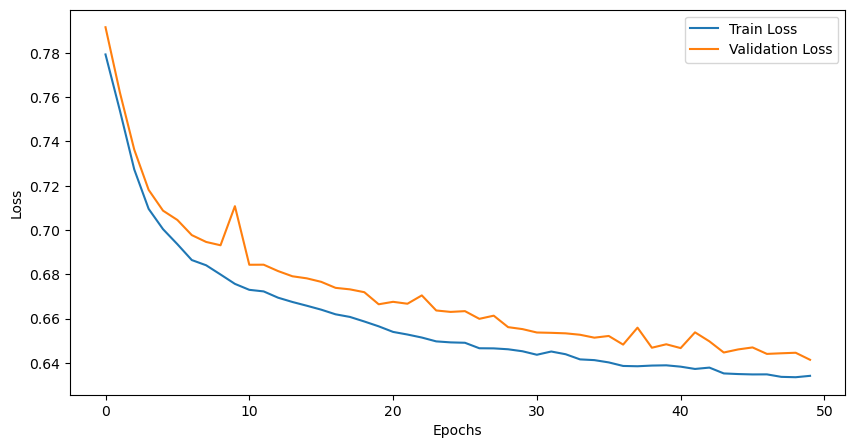

In [48]:
fit(
    model,
    loss_fn,
    optimizer,
    x_train_tensor,
    x_val_tensor,
    epochs=50,
    batch_size=50
)

In [60]:
model.eval()
with torch.no_grad():
    x_val_hat = model(x_val_tensor.to(next(model.parameters()).device)).cpu()
mse_val = ((x_val_hat - x_val_tensor)**2).mean(dim=1).numpy()
threshold = np.quantile(mse_val, 0.99)


In [61]:

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    x_test_hat = model(x_test_tensor.to(next(model.parameters()).device)).cpu()
mse_test = ((x_test_hat - x_test_tensor)**2).mean(dim=1).numpy()

y_pred = (mse_test > threshold).astype(int)   # 1 = anomalie

In [62]:
confusion_matrix = evaluate_model(y_test, y_pred)
print_evaluation(confusion_matrix)

Confusion Matrix:
[[56315   548]
 [  158   334]]

Classification Report:
Label 0:
  precision: 0.9972
  recall: 0.9904
  f1-score: 0.9938
  support: 56863.0000
Label 1:
  precision: 0.3787
  recall: 0.6789
  f1-score: 0.4862
  support: 492.0000
